In [148]:
from keras import regularizers
from keras.utils.vis_utils import plot_model
import numpy as np
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout, TimeDistributed, Conv1D, Conv1DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import product
from sklearn.svm import SVC
from numpy.random import seed
import tensorflow
from datetime import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import sys
sys.path.append('../datasets')
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from itertools import product

# 1. Импорт данных (датасет NSL-KDD)

In [3]:
columns = ['duration','protocol_type',
           'service','flag','src_bytes',
           'dst_bytes','land','wrong_fragment',
           'urgent','hot','num_failed_logins',
           'logged_in','num_compromised','root_shell',
           'su_attempted','num_root','num_file_creations',
           'num_shells','num_access_files','num_outbound_cmds',
           'is_hot_login','is_guest_login','count','srv_count',
           'serror_rate','srv_serror_rate','rerror_rate',
           'srv_rerror_rate','same_srv_rate','diff_srv_rate',
           'srv_diff_host_rate','dst_host_count','dst_host_srv_count',
           'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
           'dst_host_rerror_rate','dst_host_srv_rerror_rate','result']

### 1.1. Загрузка тренировочных данных

In [102]:
datafarame_KDDTrain = pd.read_csv('datasets/KDDTrain+.txt', 
                                  sep=",",
                                  header=None, 
                                  names=columns, 
                                  index_col=False,
                                  on_bad_lines='skip'
                                  )

<ipython-input-102-8a5260578595>:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  datafarame_KDDTrain = pd.read_csv('datasets/KDDTrain+.txt',


In [103]:
datafarame_KDDTrain.shape

(125973, 42)

### 1.2. Загрузка тестовых данных

In [104]:
datafarame_KDDTest = pd.read_csv('datasets/KDDTest+.txt', 
                                 sep=",", 
                                 header=None, 
                                 names=columns, 
                                 index_col=False
                                 )

<ipython-input-104-e4b1a6c86993>:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  datafarame_KDDTest = pd.read_csv('datasets/KDDTest+.txt',


In [105]:
datafarame_KDDTest.shape

(22544, 42)

# 2. Обработка данных

### 2.1. Группировка данных

Группировка тренировочных данных

In [106]:
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'back'), 'result'] = 'dos'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'land'), 'result'] = 'dos'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'neptune'), 'result'] = 'dos'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'pod'), 'result'] = 'dos'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'smurf'), 'result'] = 'dos'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'teardrop'), 'result'] = 'dos'

datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'ipsweep'), 'result'] = 'probe'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'nmap'), 'result'] = 'probe'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'portsweep'), 'result'] = 'probe'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'satan'), 'result'] = 'probe'

datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'ftp_write'), 'result'] = 'r2l'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'guess_passwd'), 'result'] = 'r2l'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'guesspasswd'), 'result'] = 'r2l'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'imap'), 'result'] = 'r2l'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'multihop'), 'result'] = 'r2l'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'phf'), 'result'] = 'r2l'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'spy'), 'result'] = 'r2l'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'warezlient'), 'result'] = 'r2l'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'warezmaster'), 'result'] = 'r2l'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'warezclient'), 'result'] = 'r2l'

datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'buffer_overflow'), 'result'] = 'u2r'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'loadmodule'), 'result'] = 'u2r'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'perl'), 'result'] = 'u2r'
datafarame_KDDTrain.loc[(datafarame_KDDTrain.result == 'rootkit'), 'result'] = 'u2r'

Группировка тестовых данных

In [107]:
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'back'), 'result'] = 'dos'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'land'), 'result'] = 'dos'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'neptune'), 'result'] = 'dos'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'pod'), 'result'] = 'dos'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'smurf'), 'result'] = 'dos'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'teardrop'), 'result'] = 'dos'

datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'ipsweep'), 'result'] = 'probe'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'nmap'), 'result'] = 'probe'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'portsweep'), 'result'] = 'probe'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'satan'), 'result'] = 'probe'

datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'ftp_write'), 'result'] = 'r2l'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'guess_passwd'), 'result'] = 'r2l'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'guesspasswd'), 'result'] = 'r2l'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'imap'), 'result'] = 'r2l'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'multihop'), 'result'] = 'r2l'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'phf'), 'result'] = 'r2l'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'spy'), 'result'] = 'r2l'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'warezlient'), 'result'] = 'r2l'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'warezmaster'), 'result'] = 'r2l'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'warezclient'), 'result'] = 'r2l'

datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'buffer_overflow'), 'result'] = 'u2r'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'loadmodule'), 'result'] = 'u2r'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'perl'), 'result'] = 'u2r'
datafarame_KDDTest.loc[(datafarame_KDDTest.result == 'rootkit'), 'result'] = 'u2r'

## 2.2. Отбор групп по типу протокола

In [108]:
# Просмотр данных, сгруппированных по столбцу 'service'
new_goup_df = datafarame_KDDTrain.groupby(['service'], sort=False).size().reset_index(name='counts').sort_values(by='counts', axis=0, ascending=False)

# Создаем массив данных для того, чтобы потом легче использовать при удалении данных для Test и Train
arr = [x for x in new_goup_df[new_goup_df['counts']<500]['service']] 

In [109]:
datafarame_KDDTest = datafarame_KDDTest.loc[~datafarame_KDDTest['service'].isin(arr)]

In [110]:
datafarame_KDDTrain = datafarame_KDDTrain.loc[~datafarame_KDDTrain['service'].isin(arr)]

Отберем группу с DDOS-атакой и будем исследовать ее в дальнейшем

In [111]:
datafarame_KDDTrain_new = datafarame_KDDTrain.loc[datafarame_KDDTrain['result'].isin(['dos', 'normal'])]

In [112]:
datafarame_KDDTest_new = datafarame_KDDTest.loc[datafarame_KDDTest['result'].isin(['dos', 'normal'])]

## Преобразование групп 
Нормальные данные - "0"

Аномалии - "1"

In [113]:
datafarame_KDDTest_new.loc[(datafarame_KDDTest_new['result'] == 'normal'), 'result'] = 0
datafarame_KDDTest_new.loc[(datafarame_KDDTest_new['result'] == 'dos'), 'result'] = 1

In [114]:
datafarame_KDDTrain_new.loc[(datafarame_KDDTrain_new['result'] == 'normal'), 'result'] = 0
datafarame_KDDTrain_new.loc[(datafarame_KDDTrain_new['result'] == 'dos'), 'result'] = 1

Сводка данных 

по тренировочному набору данных

In [115]:
datafarame_KDDTrain_new.groupby(['result'], sort=False) \
                        .size() \
                        .reset_index(name='counts')

,result,counts
0,0,66701
1,1,37855


по тестовому набору данных

In [116]:
datafarame_KDDTest_new.groupby(['result'], sort=False) \
                      .size() \
                      .reset_index(name='counts')

,result,counts
0,1,5136
1,0,9675


## 2.3. Линейная звисимость

Преобразование категориальных признаков

In [117]:
datafarame_KDDTrain_new = pd.get_dummies(datafarame_KDDTrain_new, columns=['protocol_type', 'service', 'flag'])

In [118]:
datafarame_KDDTest_new = pd.get_dummies(datafarame_KDDTest_new, columns=['protocol_type', 'service', 'flag'])

Матрица линейной зависимости

In [119]:
df_corr = datafarame_KDDTrain_new.astype('float64').corr()
df_corr

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_OTH,flag_REJ,flag_RSTO,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
duration,1.000000,-0.004996,0.058280,-0.001535,-0.009754,0.014729,0.011938,0.043760,-0.038131,0.128183,...,-0.001018,-0.026937,0.005001,0.024533,-0.060289,-0.005626,-0.003149,0.003845,0.068196,-0.000434
src_bytes,-0.004996,1.000000,-0.002286,-0.000889,-0.005539,-0.000323,0.000235,-0.001196,0.033487,-0.000450,...,-0.000566,-0.015610,-0.005632,0.008461,-0.034932,0.019196,-0.000960,0.028377,0.037847,-0.000251
dst_bytes,0.058280,-0.002286,1.000000,-0.000881,-0.005597,0.029029,0.007434,0.073690,0.049844,0.120801,...,0.001127,-0.015460,-0.004240,0.003816,-0.034596,0.030573,0.033394,0.000788,0.034811,-0.000249
land,-0.001535,-0.000889,-0.000881,1.000000,-0.001520,-0.000107,-0.001377,-0.000346,-0.014378,-0.000197,...,-0.000159,-0.004199,-0.001537,-0.000518,0.025452,-0.000877,-0.000533,-0.000314,-0.020885,-0.000068
wrong_fragment,-0.009754,-0.005539,-0.005597,-0.001520,1.000000,-0.000680,-0.008755,-0.002202,-0.091396,-0.001253,...,-0.001008,-0.026692,-0.009772,-0.003290,-0.059731,-0.005573,-0.003387,-0.001994,0.072792,-0.000430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
flag_S1,-0.005626,0.019196,0.030573,-0.000877,-0.005573,-0.000392,0.000581,0.002992,0.046727,0.017387,...,-0.000582,-0.015394,-0.005636,-0.001898,-0.034448,1.000000,-0.001954,-0.001150,-0.076567,-0.000248
flag_S2,-0.003149,-0.000960,0.033394,-0.000533,-0.003387,-0.000238,0.012141,-0.000772,0.031491,-0.000429,...,-0.000353,-0.009356,-0.003425,-0.001153,-0.020937,-0.001954,1.000000,-0.000699,-0.046536,-0.000151
flag_S3,0.003845,0.028377,0.000788,-0.000314,-0.001994,-0.000140,-0.001300,-0.000454,0.019925,-0.000151,...,-0.000208,-0.005507,-0.002016,-0.000679,-0.012324,-0.001150,-0.000699,1.000000,-0.027393,-0.000089
flag_SF,0.068196,0.037847,0.034811,-0.020885,0.072792,0.005121,0.061824,0.011045,0.661715,0.006811,...,-0.013853,-0.366690,-0.134244,-0.045202,-0.820566,-0.076567,-0.046536,-0.027393,1.000000,-0.005907


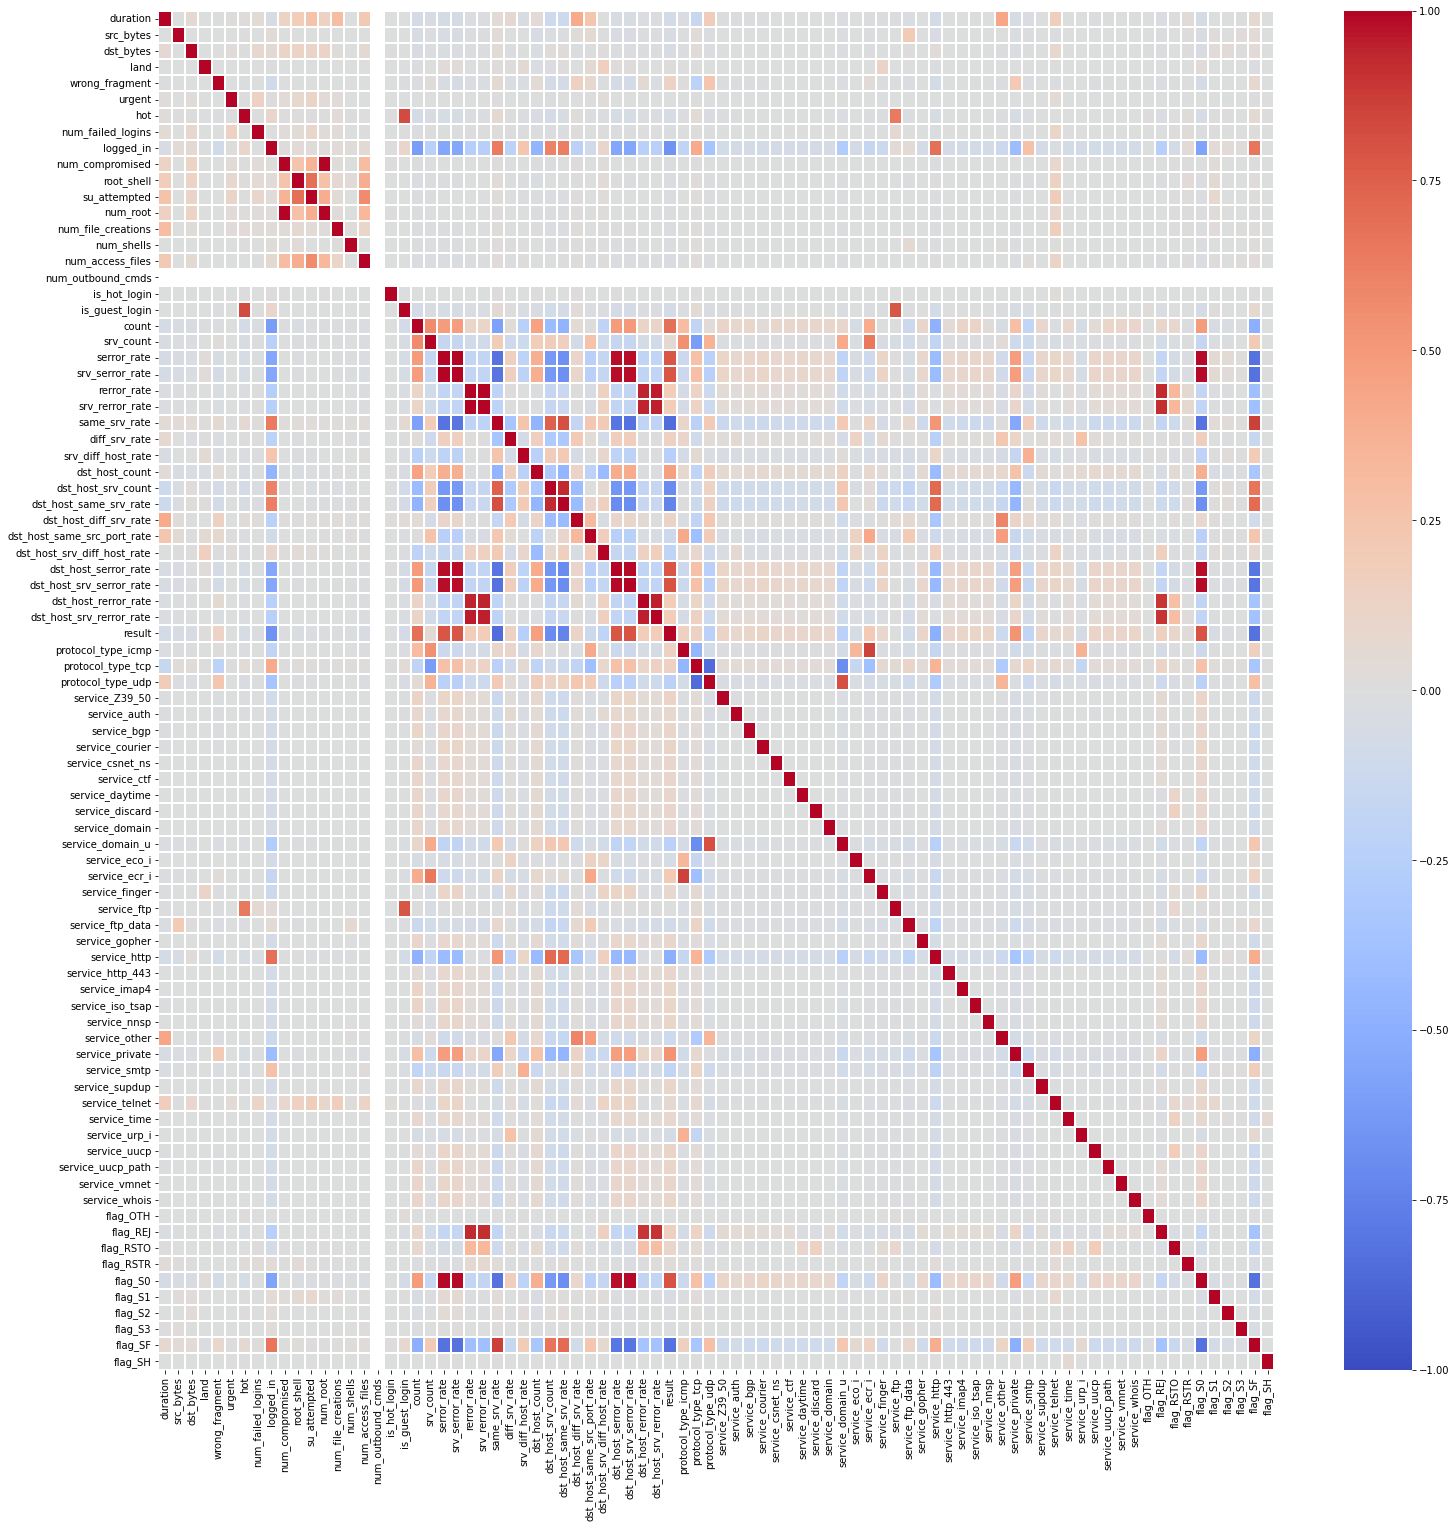

In [120]:
plt.figure(figsize = (25,25)) # для разборчивого формата
sns.heatmap(df_corr,  
            vmin=-1, 
            vmax=1, 
            center= 0, 
            cmap= 'coolwarm', 
            linewidths=.1)
plt.savefig('HeatMap_linearCorr')

Выборка данных, у которых коэффициент корреляции больше 0.8 (удаление столбцов при коэффициент корреляции меньше 0.8 )

In [121]:
datafarame_KDDTrain_new = datafarame_KDDTrain_new.drop([
                                                        'is_guest_login',
                                                        "hot", "num_root", "srv_serror_rate", 'num_outbound_cmds',
                                                        "srv_serror_rate","dst_host_serror_rate", "dst_host_srv_serror_rate",
                                                        "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "srv_rerror_rate",
                                                        "dst_host_srv_count", "dst_host_same_srv_rate", 
                                                        
                                                        'flag_S0', 'flag_REJ', 'flag_SF','flag_OTH', 'flag_SH' , 
                                                        'service_ecr_i', 'service_domain_u' # 'service_red_i', 'service_urh_i',
                                                        ], axis=1)

In [122]:
datafarame_KDDTest_new = datafarame_KDDTest_new.drop([
                                                        'is_guest_login',
                                                        "hot", "num_root", 'num_outbound_cmds',
                                                        "srv_serror_rate","dst_host_serror_rate", "dst_host_srv_serror_rate",
                                                        "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "srv_rerror_rate",
                                                        "dst_host_srv_count", "dst_host_same_srv_rate", 
                                                      
                                                        'flag_S0', 'flag_REJ', 'flag_SF', 'service_ecr_i', 'service_domain_u',
                                                        'flag_RSTOS0'
                                                        ], axis=1)

## 2.4. Разделение данных перед использование автоэнкодеров

In [123]:
seed(1)
tensorflow.random.set_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

In [124]:
datafarame_KDDTrain_new, datafarame_KDDTrain_new_valid = train_test_split(datafarame_KDDTrain_new, 
                                                                          test_size=DATA_SPLIT_PCT, 
                                                                          random_state=SEED)

In [125]:
datafarame_KDDTrain_new_0 = datafarame_KDDTrain_new.loc[datafarame_KDDTrain_new['result'] == 0]
datafarame_KDDTrain_new_1 = datafarame_KDDTrain_new.loc[datafarame_KDDTrain_new['result'] == 1]
datafarame_KDDTrain_new_0_x = datafarame_KDDTrain_new_0.drop(['result'], axis=1)
datafarame_KDDTrain_new_1_x = datafarame_KDDTrain_new_1.drop(['result'], axis=1)

In [126]:
datafarame_KDDTrain_new_valid_0 = datafarame_KDDTrain_new_valid.loc[datafarame_KDDTrain_new_valid['result'] == 0]
datafarame_KDDTrain_new_valid_1 = datafarame_KDDTrain_new_valid.loc[datafarame_KDDTrain_new_valid['result'] == 1]
datafarame_KDDTrain_new_valid_0_x = datafarame_KDDTrain_new_valid_0.drop(['result'], axis=1)
datafarame_KDDTrain_new_valid_1_x = datafarame_KDDTrain_new_valid_1.drop(['result'], axis=1)

In [127]:
datafarame_KDDTest_new_0 = datafarame_KDDTest_new.loc[datafarame_KDDTest_new['result'] == 0]
datafarame_KDDTest_new_1 = datafarame_KDDTest_new.loc[datafarame_KDDTest_new['result'] == 1]
datafarame_KDDTest_new_0_x = datafarame_KDDTest_new_0.drop(['result'], axis=1)
datafarame_KDDTest_new_1_x = datafarame_KDDTest_new_1.drop(['result'], axis=1)

In [128]:
scaler = StandardScaler().fit(datafarame_KDDTrain_new_0_x)
datafarame_KDDTrain_new_0_x_rescaled = scaler.transform(datafarame_KDDTrain_new_0_x)

datafarame_KDDTrain_new_valid_0_x_rescaled = scaler.transform(datafarame_KDDTrain_new_valid_0_x)
datafarame_KDDTrain_new_valid_x_rescaled = scaler.transform(datafarame_KDDTrain_new_valid.drop(['result'], axis = 1))

datafarame_KDDTest_new_0_x_rescaled = scaler.transform(datafarame_KDDTest_new_0_x)
datafarame_KDDTest_new_x_rescaled = scaler.transform(datafarame_KDDTest_new.drop(['result'], axis = 1))

# 3. Реализация автоэнкодеров

## 3.1. Feed-Forward Autoencoder

In [129]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

### 3.1.1. Нахождение лучших параметров для Feed-Forward автоэнкодера

In [130]:
# StSc = StandardScaler()

# # scaler fitting
# # StSc.fit(X_train)
# # X_val = datafarame_KDDTrain_new[700:1000].drop('result', axis=1)
# # StSc.fit(X_val)

# n1=[30, 31] # было n1=[14, 13]
# n2=[14, 15] # было n2=[7, 6]
# n3=[6, 7] # было n3=[4, 3]
# n4=[2, 3] # было n4=[2, 1]
# lr=[0.01, 0.005,0.002, 0.001]
# batch_size=[20, 32, 64, 100]

# parameters = product(n1, n2, n3,n4, lr, batch_size)
# parameters_list = list(parameters)
# print(f'Total number of parameter combinations: {len(parameters_list)}')

In [131]:
# pd.DataFrame(parameters_list, columns=['neurons 1st layer','neurons 2st layer',
#                                       'neurons 3nd layer',
#                                       'neurons 4rd layer',
#                                       'learning rate',
#                                       'batch size'])

In [132]:
# errors = []
# cnt = 1 
# for params in parameters_list:
#     # datafarame_KDDTrain_new_0_x_rescaled, datafarame_KDDTrain_new_valid_0_x_rescaled
#     print(cnt, params)
#     model = newArchFeedForwardAE(params, datafarame_KDDTrain_new_0_x_rescaled[:1500], datafarame_KDDTrain_new_valid_0_x_rescaled[:1000])
    
#     train_pred = model.predict(datafarame_KDDTrain_new_0_x_rescaled[:1500], batch_size=params[5])
#     val_pred = model.predict(datafarame_KDDTrain_new_valid_0_x_rescaled[:1500], batch_size=params[5])
    
#     train_error = mean_absolute_error(datafarame_KDDTrain_new_0_x_rescaled[:1500], train_pred)
#     val_error = mean_absolute_error(datafarame_KDDTrain_new_valid_0_x_rescaled[:1500], val_pred)
    
#     errors.append(list(params)+[train_error, val_error])
#     cnt += 1
    
# df_errors = pd.DataFrame(errors,
#                          columns=['neurons 1st layer','neurons 2st layer', 
#                                   'neurons 3nd layer', 
#                                   'neurons 4rd layer', 
#                                   'learning rate', 
#                                   'batch size', 
#                                   'mae train', 
#                                   'mae val'])
# df_errors.sort_values('mae val').head()

In [133]:
# best_params = parameters_list[df_errors.sort_values('mae val').index[0]]
# best_params 
# # (30, 15, 7, 3, 0.005, 64)
# # # (8, 5, 2, 0.01, 64) при 3 скрытых слоях
# # # (18, 8, 4, 2, 0.01, 32) при 4 скрытых слоях
# # # (13, 7, 4, 2, 0.01, 64)

### 3.1.2. Реализация Feed-Forward автоэнкодера


In [135]:
def newArchFeedForwardAE(param, data, valid_data):
    Random(0)
    learning_rate = 1e-3
    input_dots = Input((data.shape[1],))

    x = Dense(param[0], activity_regularizer=regularizers.l1(learning_rate))(input_dots)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(param[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(param[2])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
#     x = Dense(param[3])(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

    bottleneck = Dense(param[3], activation='linear')(x)
    
    x = Dense(param[2])(bottleneck)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(param[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(param[0])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

#     x = Dense(param[0])(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

    out = Dense(data.shape[1], activation='linear')(x)

    model = Model(input_dots, out)
    model.compile(optimizer=Adam(param[4]), loss='mae', metrics=["mse", "accuracy"])
    print(model.summary())
    plot_model(model, to_file='model_plot_FF_AE.png', show_shapes=True, show_layer_names=True)

    early_stopping = EarlyStopping(patience=3, verbose=0)
    
    model.fit(data, data,
                validation_split=0.2,
                epochs=200,
                batch_size=param[5],
                verbose=0,
                shuffle=True,
                #callbacks=[early_stopping],
                validation_data= (valid_data, valid_data)
               )
    
    
    plt.plot(model.history.history['loss'], label='train')
    plt.plot(model.history.history['val_loss'], label='test')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    return model

In [136]:
BEST_PARAMS = [30, 15, 7, 3, 0.005, 64]  

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 batch_normalization (BatchN  (None, 30)               120       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 batch_normalization_1 (Batc  (None, 15)               60        
 hNormalization)                                             

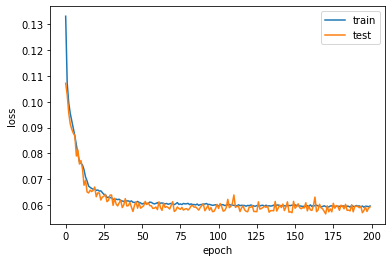

In [137]:
start_time = datetime.now()
model_ff = newArchFeedForwardAE(BEST_PARAMS, 
                                datafarame_KDDTrain_new_0_x_rescaled, 
                                datafarame_KDDTrain_new_valid_0_x_rescaled)
work_time_ff_autoen = datetime.now() - start_time

In [138]:
valid_x_predictions_ff = model_ff.predict(datafarame_KDDTrain_new_valid_x_rescaled)

mse = np.mean(np.power(datafarame_KDDTrain_new_valid_x_rescaled - valid_x_predictions_ff, 2), axis=1)
error_df_ff = pd.DataFrame({'Reconstruction_error': mse,
                            'True_class': datafarame_KDDTrain_new_valid['result']})

654/654 [==============================] - 2s 2ms/step


### 3.1.3. Оценка Feed-Forward автоэнкодера

In [139]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score


precision_rt_ff, recall_rt_ff, threshold_rt_ff = precision_recall_curve(error_df_ff.True_class.astype(int), 
                                                               error_df_ff.Reconstruction_error)

In [140]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Line(
        x=threshold_rt_ff[:10000],
        y=precision_rt_ff[1:], name='precision'
    ))

fig.add_trace(
    go.Line(
        x=threshold_rt_ff[:10000],
        y=recall_rt_ff[1:], name='recall'
    ))

fig.show()

/usr/local/lib/python3.9/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




Найдем индексы пересечения

In [141]:
equal_val = []
equal_ind = []

for i in precision_rt_ff:
  for j in enumerate(recall_rt_ff):
    if i == j[1] and (i>0.88) and (i<0.89):
      equal_val.append(j[1])
      equal_ind.append(j[0])

equal_ind, equal_val

([13187, 13192, 13205, 13243],
 [0.8888888888888888,
  0.888235294117647,
  0.8866666666666667,
  0.8823529411764706])

Усредненное значение порога

In [142]:
thre_val_ff = [threshold_rt_ff[equal_ind[i]] for i in range(len(equal_ind))]

threshold_mean_ff = np.mean(thre_val_ff)
threshold_mean_ff

1.56549818659012

463/463 [==============================] - 1s 2ms/step


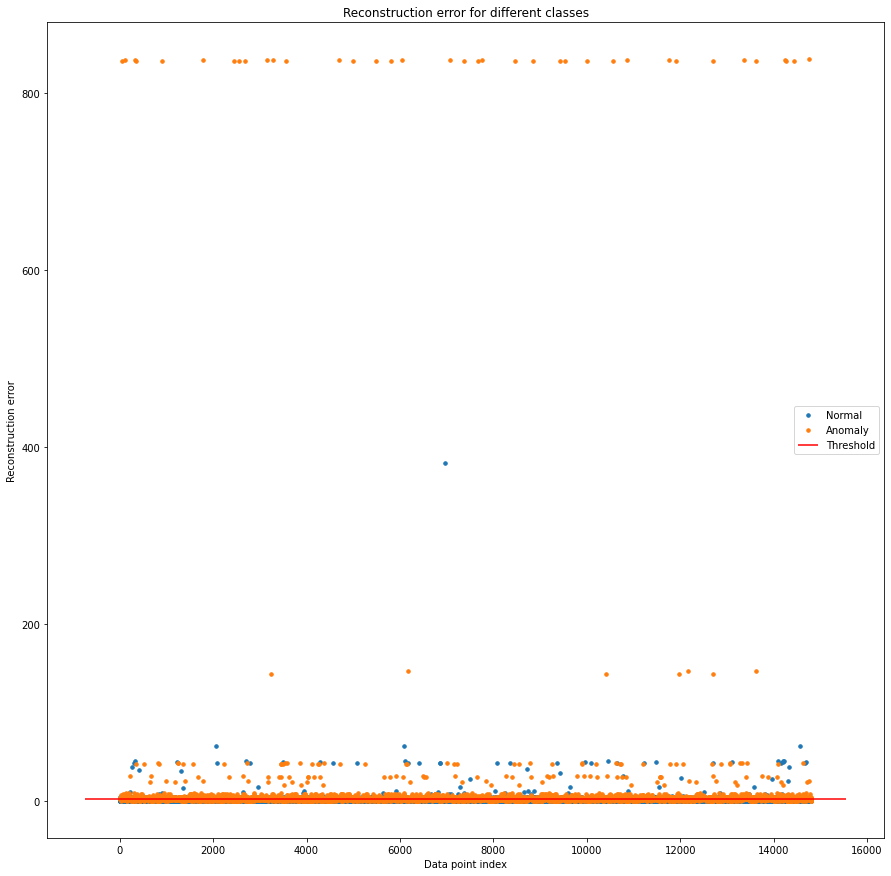

In [143]:
test_x_predictions_ff = model_ff.predict(datafarame_KDDTest_new_x_rescaled)
mse = np.mean(np.power(datafarame_KDDTest_new_x_rescaled - test_x_predictions_ff, 2), axis=1)
error_df_test_ff = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': datafarame_KDDTest_new['result']})

error_df_test_ff = error_df_test_ff.reset_index()
threshold_fixed = threshold_mean_ff # 1.45 # 2.5

groups = error_df_test_ff.groupby('True_class')

fig, ax = plt.subplots(figsize=(15,15))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")


ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.savefig('Reconstruction error_FF_ae')
plt.show()

Матрица (TP, TN, FP, FN)

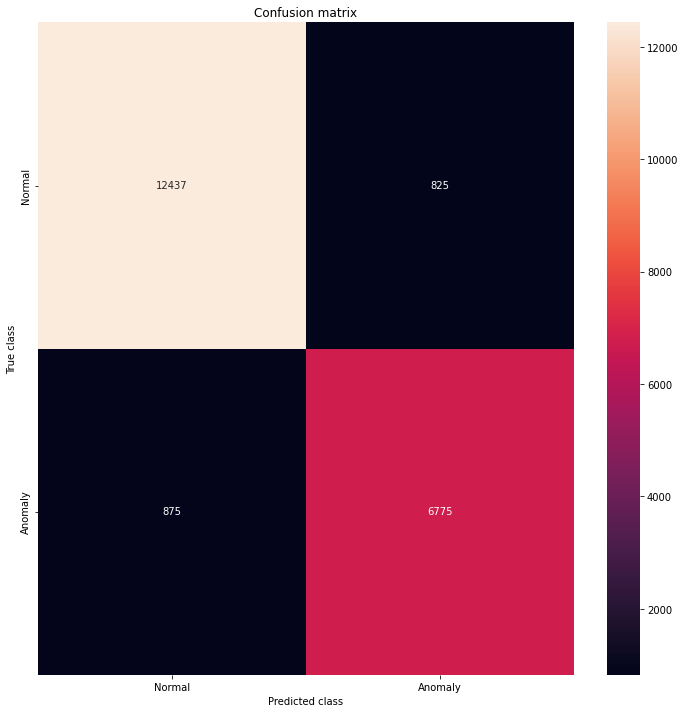

In [144]:
LABELS = ["Normal","Anomaly"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df_ff.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_ff.True_class.astype(int), pred_y)

plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('HeatMap_FF_ae')
plt.show()

AUC-ROC оценка

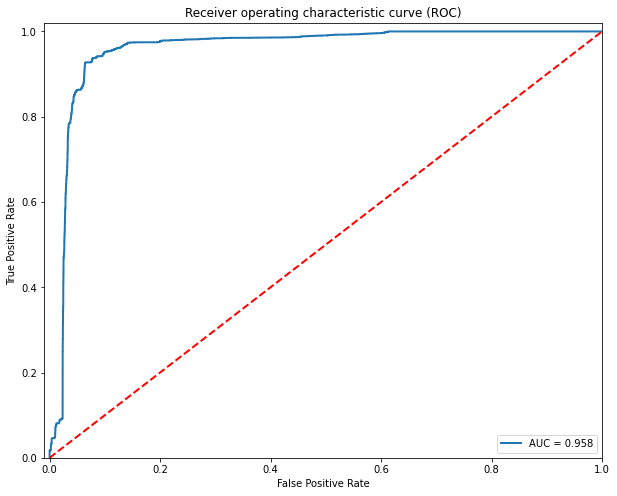

In [145]:
false_pos_rate_ff, true_pos_rate_ff, thresholds_ff = roc_curve(error_df_ff.True_class.astype(int), error_df_ff.Reconstruction_error)
roc_auc_ff = auc(false_pos_rate_ff, true_pos_rate_ff,)

plt.figure(figsize=(10, 8))
plt.plot(false_pos_rate_ff, true_pos_rate_ff, linewidth=2, label='AUC = %0.3f'% roc_auc_ff)
plt.plot([0,1],[0,1],'r--', linewidth=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_FF_ae')
plt.show()

In [146]:
print(classification_report(error_df_ff.True_class.astype(int), pred_y))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     13262
           1       0.89      0.89      0.89      7650

    accuracy                           0.92     20912
   macro avg       0.91      0.91      0.91     20912
weighted avg       0.92      0.92      0.92     20912



In [147]:
with open('results.txt', 'a', encoding='UTF-8') as f:
  f.write(f'FeedForward NN \n {classification_report(error_df_ff.True_class.astype(int), pred_y)} \nWork time of FF autoencoder = {work_time_ff_autoen} \nAUC = {round(roc_auc_ff,3)} \n')

## 3.2. Convolutional Autoencoder

### 3.2.1. Нахождение лучших параметров для Feed-Forward автоэнкодера

In [149]:
# StSc = StandardScaler()


# n1=[30, 31]
# # n2=[7, 6]
# kearnel = [3, 4, 5, 6, 7]
# strides = [2]
# lr=[0.01, 0.005,0.002, 0.001]
# batch_size=[ 30, 60, 80, 97]

# parameters = product(n1, kearnel,strides, lr, batch_size)
# parameters_list = list(parameters)
# print(f'Total number of parameter combinations: {len(parameters_list)}')

In [150]:
# pd.DataFrame(parameters_list, columns=['neurons 1st layer',
# #                                        'neurons 2st layer', 
#                                        'kernel_size', 'strides',
#                                        'learning rate',
#                                        'batch size'])

In [ ]:
# X = datafarame_KDDTrain_new_0_x_rescaled[:1000]
# V = datafarame_KDDTrain_new_valid_0_x_rescaled[:1000]

# h, w = X.shape
# input_shape = (h,w,1)

# X.shape, V.shape

In [ ]:
# errors = []
# cnt = 1 
# for params in parameters_list:
#     # datafarame_KDDTrain_new_0_x_rescaled, datafarame_KDDTrain_new_valid_0_x_rescaled
#     print(cnt, params)
#     X = datafarame_KDDTrain_new_0_x_rescaled[:1000]
#     V = datafarame_KDDTrain_new_valid_0_x_rescaled[:1000]
    
#     model = newArchConv(params, X, V)
    
#     train_pred = model.predict(X, batch_size=params[4])
#     val_pred = model.predict(V, batch_size=params[4])
    
#     new_shape = X.shape
#     print(train_pred.shape)
#     train_error = mean_absolute_error(X, np.resize(train_pred, new_shape))
#     val_error = mean_absolute_error(V, np.resize(val_pred, new_shape))
    
#     errors.append(list(params)+[train_error, val_error])
#     cnt += 1
    
# df_errors = pd.DataFrame(errors,
#                          columns=['neurons 1st layer','kernel_size', 'strides',
# #                                   'neurons 3nd layer', 
# #                                   'neurons 4rd layer', 
#                                   'learning rate', 
#                                   'batch size', 
#                                   'mae train', 
#                                   'mae val'])
# df_errors.sort_values('mae val').head()

In [151]:
# best_params_conv = parameters_list[df_errors.sort_values('mae val').index[0]]
# best_params_conv

### 3.2.2. Реализация Convolutional автоэнкодера

In [153]:
# Generated training sequences for use in the model.
N_STEPS = 1 #996 #60
Q = 0.999 # quantile for upper control limit (UCL) selection
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [154]:
def newArchConv(param, data, valid_data):
    Random(0)

    h, w = data.shape
    input_shape = (h,w,1)

    model = Sequential(
        [
            Input(shape=(input_shape[1], input_shape[2])), # Input((38,))
            
            Conv1D( 
                filters=data.shape[1], kernel_size=param[1], padding="same", strides=param[2], activation="relu"
            ),
            Dropout(rate=0.2),
            Conv1D(
                filters=param[0], kernel_size=param[1], padding="same", strides=param[2], activation="relu"
            ),
#             Dropout(rate=0.2),
#             Conv1D(
#                 filters=param[1], kernel_size=param[2], padding="same", strides=param[3], activation="relu"
#             ),
        ########################################\
#             Conv1DTranspose(
#                 filters=param[1], kernel_size=param[2], padding="same", strides=param[3], activation="relu"
#             ),
#             Dropout(rate=0.2),
            Conv1DTranspose(
                filters=param[0], kernel_size=param[1], padding="same", strides=param[2], activation="relu"
            ),
            Dropout(rate=0.2),
            Conv1DTranspose(
                filters=data.shape[1], kernel_size=param[1], padding="same", strides=param[2], activation="relu"
            ),
            
            Conv1DTranspose(filters=1, kernel_size=param[1], padding="same"),
        ]
    )
    model.compile(optimizer=Adam(learning_rate=param[3]), loss="mse")
    print(model.summary())
    plot_model(model, to_file='model_plot_Conv_AE.png', show_shapes=True, show_layer_names=True)

    early_stopping = EarlyStopping(patience=3, verbose=0)

    model.fit(data, data,
                    validation_split=0.2,
                    epochs=200,
                    batch_size=param[4],
                    verbose=0,
#                   shuffle=True,
                    callbacks=[early_stopping],
                    validation_data = (valid_data, valid_data)
                    )
    
    plt.plot(model.history.history['loss'], label='train')
    plt.plot(model.history.history['val_loss'], label='test')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    return  model

In [155]:
BEST_PARAMS_conv = [ 31, 7, 2, 0.001, 97 ]  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 32, 64)            512       
                                                                 
 dropout_2 (Dropout)         (None, 32, 64)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 16, 31)            13919     
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 32, 31)           6758      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 32, 31)            0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 64, 64)           13952     
 ranspose)                                            

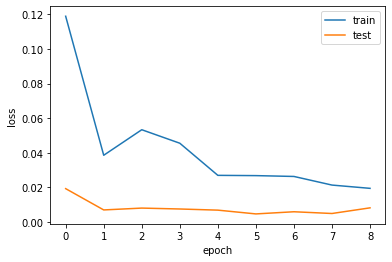

In [164]:
start_time = datetime.now()
model_conv = newArchConv(BEST_PARAMS_conv, 
                         datafarame_KDDTrain_new_0_x_rescaled, 
                         datafarame_KDDTrain_new_valid_0_x_rescaled)
work_time_conv_autoen = datetime.now() - start_time

In [165]:
valid_Conv_x_predictions = model_conv.predict(datafarame_KDDTrain_new_valid_x_rescaled)
valid_Conv_x_predictions.shape

654/654 [==============================] - 4s 6ms/step


(20912, 64, 1)

In [166]:
valid_Conv_x_predictions = np.reshape(valid_Conv_x_predictions, 
                                      datafarame_KDDTrain_new_valid_x_rescaled.shape)
valid_Conv_x_predictions.shape

(20912, 64)

### 3.2.3. Оценка Convolutional автоэнкодера

In [167]:
mse = np.mean(np.power(datafarame_KDDTrain_new_valid_x_rescaled - valid_Conv_x_predictions, 2), axis=1)

In [168]:
error_df_conv = pd.DataFrame({'Reconstruction_error': mse,
                              'True_class': datafarame_KDDTrain_new_valid['result']})

In [169]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score


precision_rt_conv, recall_rt_conv, threshold_rt_conv = precision_recall_curve(error_df_conv.True_class.astype(int), 
                                                                              error_df_conv.Reconstruction_error)

Найдем индексы пересечения

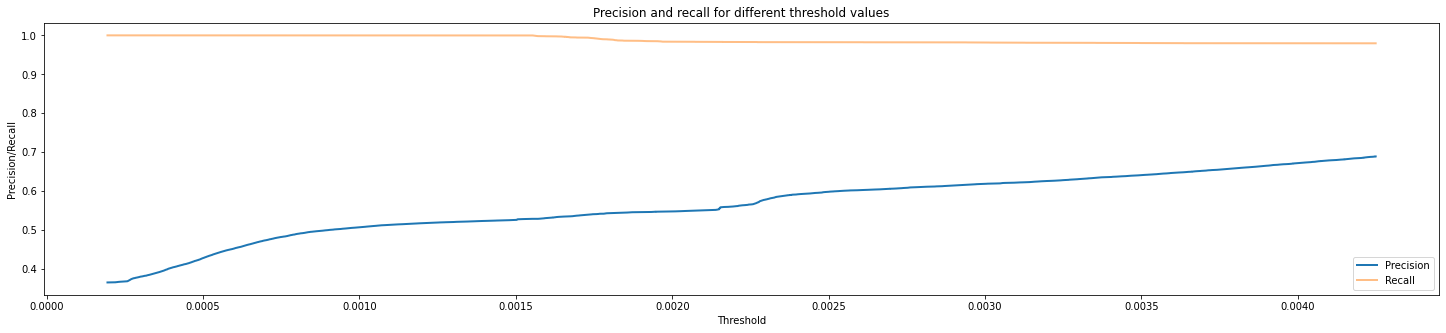

In [170]:
plt.figure(figsize = (25,5))
plt.plot(threshold_rt_conv[:10000], precision_rt_conv[1:10001], label="Precision", linewidth=2)
plt.plot(threshold_rt_conv[:10000], recall_rt_conv[1:10001], label="Recall", linewidth=2, alpha=.5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.savefig('Precision_Recall_Conv_ae')
plt.show()

In [ ]:
equal_val_conv = []
equal_ind_conv = []

for i in precision_rt_conv:
  for j in enumerate(recall_rt_conv):
    if i == j[1] and (i>0.92) and (i<0.94):
      equal_val_conv.append(j[1])
      equal_ind_conv.append(j[0])

Усредненное значение порога

In [172]:
thre_val_conv = [threshold_rt_conv[equal_ind_conv[i]] for i in range(len(equal_ind_conv))]

threshold_mean_conv = np.mean(thre_val_conv)
threshold_mean_conv

0.022967421332392178

463/463 [==============================] - 3s 6ms/step


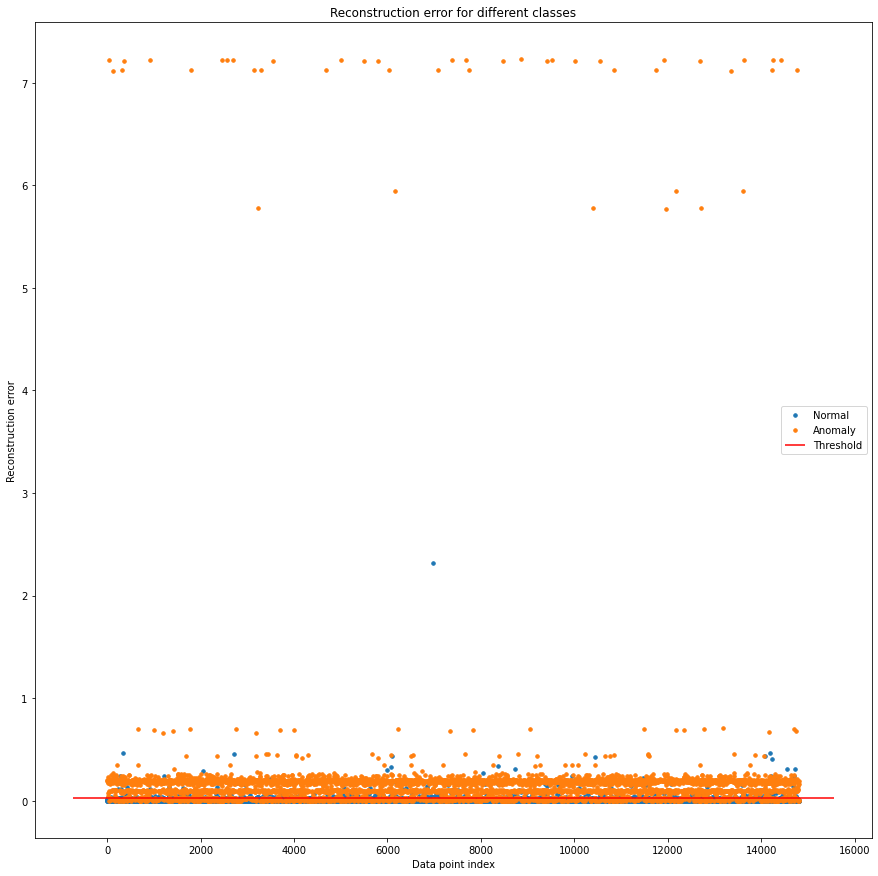

In [173]:
test_x_predictions_conv = model_conv.predict(datafarame_KDDTest_new_x_rescaled)
test_x_predictions_conv = np.reshape(test_x_predictions_conv, datafarame_KDDTest_new_x_rescaled.shape)

mse = np.mean(np.power(datafarame_KDDTest_new_x_rescaled - test_x_predictions_conv, 2), axis=1)
error_df_test_conv = pd.DataFrame({'Reconstruction_error': mse,
                                   'True_class': datafarame_KDDTest_new['result']})

error_df_test_conv = error_df_test_conv.reset_index()
threshold_fixed = threshold_mean_conv # 0.12 #0.45 #2.5

groups = error_df_test_conv.groupby('True_class')

fig, ax = plt.subplots(figsize=(15,15))
for name, group in groups:
    ax.plot(group.index, 
            group.Reconstruction_error, 
            marker='o', 
            ms=3.5, 
            linestyle='',
            label= "Anomaly" if name == 1 else "Normal")


ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.savefig('Reconstruction error_Conv_ae')
plt.show()

Матрица (TP, TN, FP, FN)

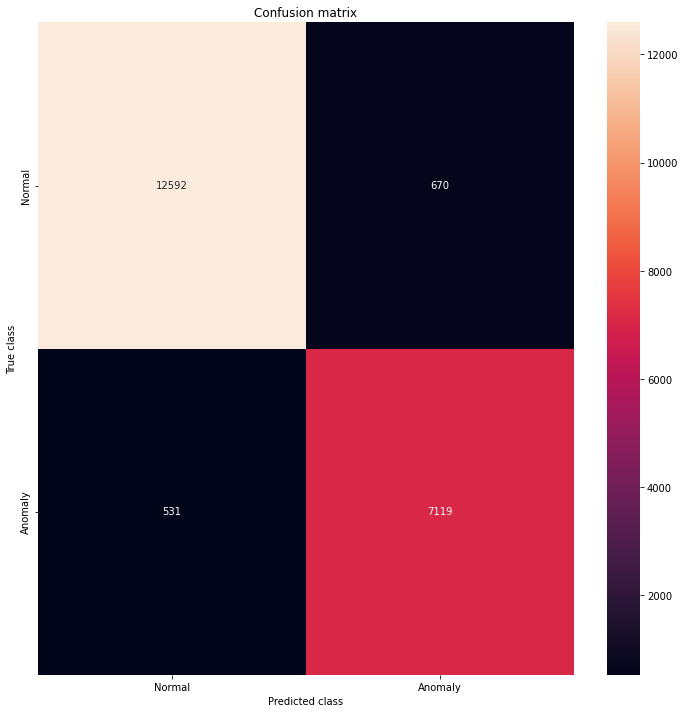

In [174]:
LABELS = ["Normal","Anomaly"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df_conv.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_conv.True_class.astype(int), pred_y)

plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('HeatMap_Conv_ae')
plt.show()

AUC-ROC оценка

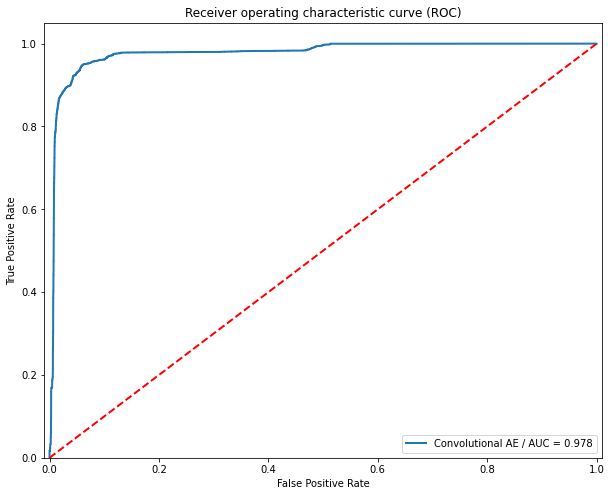

In [175]:
false_pos_rate_conv, true_pos_rate_conv, thresholds_conv = roc_curve(error_df_conv.True_class.astype(int), error_df_conv.Reconstruction_error)
roc_auc_conv = auc(false_pos_rate_conv, true_pos_rate_conv,)

plt.figure(figsize=(10, 8))
plt.plot(false_pos_rate_conv, true_pos_rate_conv, linewidth=2, label='Convolutional AE / AUC = %0.3f'% roc_auc_conv)
# plt.plot(false_pos_rate_ff, true_pos_rate_ff, linewidth=2, label='Feed-Forward AE / AUC = %0.3f'% roc_auc_ff)
plt.plot([0,1],[0,1],'r--', linewidth=2)
plt.xlim([-0.01, 1.01])
plt.ylim([0, 1.05])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_Conv_ae')
plt.show()

In [176]:
print(classification_report(error_df_conv.True_class.astype(int), pred_y))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     13262
           1       0.91      0.93      0.92      7650

    accuracy                           0.94     20912
   macro avg       0.94      0.94      0.94     20912
weighted avg       0.94      0.94      0.94     20912



In [177]:
with open('results.txt', 'a', encoding='UTF-8') as f:
  f.write(f'\n\nConvolutional NN \n {classification_report(error_df_conv.True_class.astype(int), pred_y)} \nWork time of Conv autoencoder = {work_time_conv_autoen} \nAUC = {round(roc_auc_conv,3)}\n')

# Реализация методов машинного обучения

## 4.1. Логистическая регрессия

Подготовка данных для логистической регрессии

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

scaler = StandardScaler().fit(datafarame_KDDTrain_new.loc[:,datafarame_KDDTrain_new.columns !='result'])
# datafarame_KDDTrain_new_0_x_rescaled = scaler.transform(datafarame_KDDTrain_new_0_x)
# datafarame_KDDTrain_new_valid
X_test = datafarame_KDDTrain_new_valid_x_rescaled
X_train = scaler.transform(datafarame_KDDTrain_new.loc[:, datafarame_KDDTrain_new.columns !='result'])

y_train = datafarame_KDDTrain_new['result'].astype('int')
y_test = datafarame_KDDTrain_new_valid['result'].astype('int')

### 4.1.1. Реализация логистической регрессии

In [179]:
start_time = datetime.now()
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
work_time_log_reg = datetime.now() - start_time

y_pred = logreg.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### 4.1.2. Оценка логистической регрессии

In [180]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.62


Матрица (TP, TN, FP, FN)

In [181]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

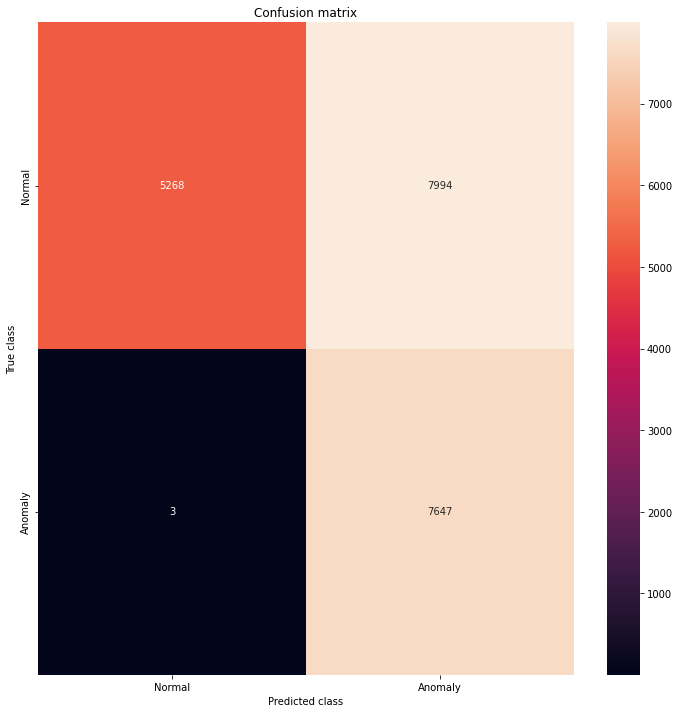

In [182]:
plt.figure(figsize=(12, 12))
LABELS = ["Normal","Anomaly"]

sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS,  annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('HeatMap_Log_Reg')
plt.show()

AUC-ROC оценка

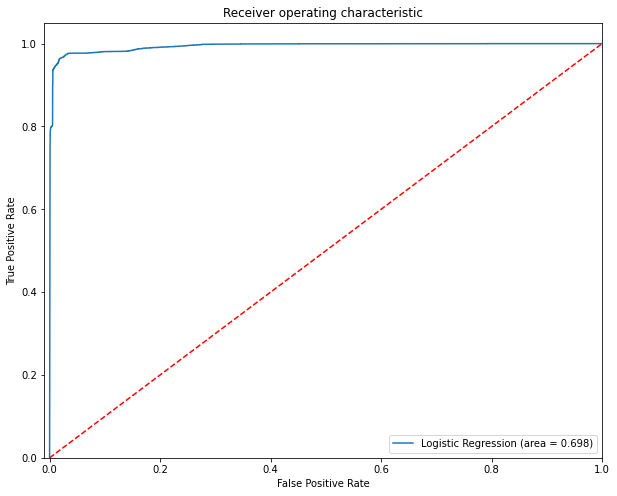

In [183]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
logit_fpr, logit_tpr, logit_thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
# print(logreg.predict_proba(X_test)[:, :])
# print(y_test)

plt.figure(figsize=(10, 8))
plt.plot(logit_fpr, logit_tpr, label='Logistic Regression (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_log_reg')
plt.show()

In [184]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.40      0.57     13262
           1       0.49      1.00      0.66      7650

    accuracy                           0.62     20912
   macro avg       0.74      0.70      0.61     20912
weighted avg       0.81      0.62      0.60     20912



In [185]:
with open('results.txt', 'a', encoding='UTF-8') as f:
  f.write(f'\n\nLOG REG \n {classification_report(y_test, y_pred)} \nWork time of Log Reg = {work_time_log_reg} \nAUC = {round(logit_roc_auc,3)}\n')

## 4.2. Метод опорных векторов (SVM)

### 4.2.1. Реализация метода опорных веторов

In [191]:
start_time = datetime.now()
svm_model = SVC(probability=True) # C=0.1, kernel='poly', gamma='scale', probability=True

train_pred = svm_model.fit(X_train, y_train)
work_time_svm = datetime.now() - start_time

y_pred_svm = svm_model.predict(X_test)

### 4.2.2. Оценка метода опорных векторов

In [192]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(svm_model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


Матрица (TP, TN, FP, FN)

In [195]:
from sklearn.metrics import confusion_matrix
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)

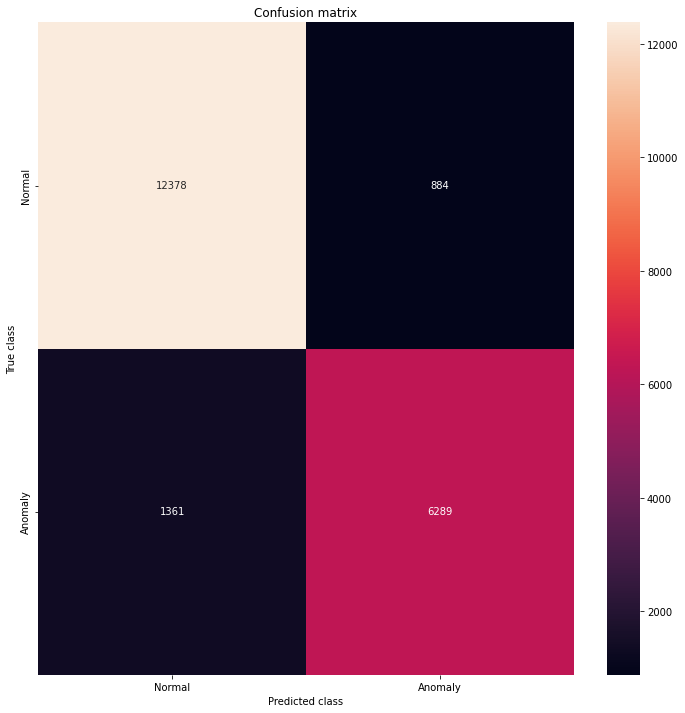

In [196]:
plt.figure(figsize=(12, 12))
LABELS = ["Normal","Anomaly"]

sns.heatmap(confusion_matrix_svm, xticklabels=LABELS, yticklabels=LABELS,  annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('HeatMap_SVM_with_parametrs')
plt.show()

AUC-ROC оценка

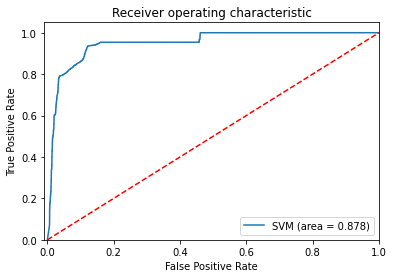

In [194]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

svm_roc_auc = roc_auc_score(y_test, y_pred_svm)
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm_model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(svm_fpr, svm_tpr, label='SVM (area = %0.3f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_SVM')
plt.show()
# svm_roc_auc

In [197]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     13262
           1       0.88      0.82      0.85      7650

    accuracy                           0.89     20912
   macro avg       0.89      0.88      0.88     20912
weighted avg       0.89      0.89      0.89     20912



In [198]:
with open('results.txt', 'a', encoding='UTF-8') as f:
  f.write(f'\n\nSVM \n {classification_report(y_test, y_pred_svm)} \nWork time of SVM = {work_time_svm} \nAUC = {round(svm_roc_auc, 3)}\n')

# Единый график ROC-AUC для всех моделей

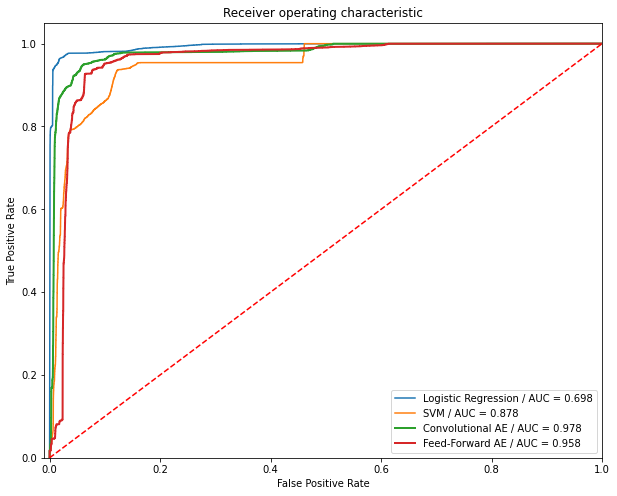

In [199]:
plt.figure(figsize=(10, 8))
plt.plot(logit_fpr, logit_tpr, label='Logistic Regression / AUC = %0.3f' % logit_roc_auc)
plt.plot(svm_fpr, svm_tpr, label='SVM / AUC = %0.3f' % svm_roc_auc)
plt.plot(false_pos_rate_conv, true_pos_rate_conv, linewidth=2, label='Convolutional AE / AUC = %0.3f'% roc_auc_conv)
plt.plot(false_pos_rate_ff, true_pos_rate_ff, linewidth=2, label='Feed-Forward AE / AUC = %0.3f'% roc_auc_ff)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Union_AUC_ROC')
plt.show()